## Import/Install Packages

In [27]:
!pip install pmdarima

In [28]:
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np
from numpy import log
from pylab import rcParams
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

In [30]:
def plot_df(df, title="", xlabel='Date', ylabel='Value', dpi=100):
  # Configure plot size and layout
  fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

  # Plot the dataset
  plt.plot(df['invoice_date'], df['sale_value'])

  # Set x label
  plt.xlabel('invoice_date')

  # Set y label
  plt.ylabel('sale_value')

In [31]:
def aggregate(df, fill='zero'):
  if fill == 'mean':
    # Aggregate sales sum grouped by date
    df_aggregated = df.groupby('invoice_date').agg({'sale_value': 'sum'}).reset_index()

    # Create range of dates in the dataset
    full_date_range = pd.date_range(start=df_aggregated['invoice_date'].min(), end=df_aggregated['invoice_date'].max())

    # Fill in the missing dates with mean
    df_aggregated_full = df_aggregated.set_index('invoice_date').reindex(full_date_range, fill_value=df_aggregated['sale_value'].mean()).reset_index()

    # Rename columns back to original titles
    df_aggregated_full.columns = ['invoice_date', 'sale_value']

    # Display the new df
    df_aggregated_full

    return df_aggregated_full
  if fill == 'zero':
    # Aggregate sales sum grouped by date
    df_aggregated = df.groupby('invoice_date').agg({'sale_value': 'sum'}).reset_index()

    # Create range of dates in the dataset
    full_date_range = pd.date_range(start=df_aggregated['invoice_date'].min(), end=df_aggregated['invoice_date'].max())

    # Fill in the missing dates with 0 value
    df_aggregated_full = df_aggregated.set_index('invoice_date').reindex(full_date_range, fill_value=0).reset_index()

    # Rename columns back to original titles
    df_aggregated_full.columns = ['invoice_date', 'sale_value']

    # Display the new df
    df_aggregated_full

    return df_aggregated_full

  if fill == 'interpolate':
    # Aggregate sales sum grouped by date
    df_aggregated = df.groupby('invoice_date').agg({'sale_value': 'sum'}).reset_index()

    # Create range of dates in the dataset
    full_date_range = pd.date_range(start=df_aggregated['invoice_date'].min(), end=df_aggregated['invoice_date'].max())

    # Fill in the missing dates with 0 value
    df_aggregated_full = df_aggregated.set_index('invoice_date').reindex(full_date_range, fill_value=np.nan).reset_index()

    # Interpolate the missing values
    df_aggregated_full['sale_value'] = df_aggregated_full['sale_value'].interpolate()

    # Rename columns back to original titles
    df_aggregated_full.columns = ['invoice_date', 'sale_value']

    # Display the new df
    df_aggregated_full

    return df_aggregated_full

In [32]:
def train_arima_model(df, train_size=0.8):
  # Split the data into training and testing sets
  train, test = train_test_split(df['sale_value'], train_size=train_size)

  # Run auto_arima to find best ARIMA model order
  auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=3, max_q=3, max_order=None, trace=1)

  # Create the SARIMA model
  Final_model = ARIMA(train,
                      order=auto_model.order)
  Final_output = Final_model.fit()

  # Get the forecast for test data
  forecast = Final_output.get_forecast(steps = len(test))
  forecast_conf = forecast.conf_int()

  # Plot observed values
  fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
  ax = df['sale_value'].plot()

  # Plot forecasted values
  forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(forecast_conf.index,
                  forecast_conf.iloc[:, 0],
                  forecast_conf.iloc[:, 1], color='g', alpha=0.1)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
  plt.show()

In [33]:
def sample_weekly(df, agg='mean'):
  if agg == 'mean':
    # Set invoice as index
    df = df.set_index('invoice_date')

    # Sample weekly values
    weekly_averages_mean = df['sale_value'].resample('W').mean()

    # reset the index
    weekly_averages_mean = weekly_averages_mean.reset_index()

    return weekly_averages_mean
  if agg == 'sum':
    # Set invoice as index
    df = df.set_index('invoice_date')

    # Sample weekly values
    weekly_averages_mean = df['sale_value'].resample('W').sum()

    # reset the index
    weekly_averages_mean = weekly_averages_mean.reset_index()

    return weekly_averages_mean

## TX_AUS

### DataFrames

In [34]:
# Read in the parquet file for store location
TX_AUS_DF = pd.read_parquet('/content/drive/MyDrive/data/TX_AUS.parquet')

In [35]:
daily_sales_mean = aggregate(TX_AUS_DF, fill='mean')

In [36]:
daily_sales_zero = aggregate(TX_AUS_DF, fill='zero')

In [37]:
daily_sales_interpolate = aggregate(TX_AUS_DF, fill='interpolate')

In [38]:
weekly_averages_mean = sample_weekly(daily_sales_mean, agg='mean')

In [39]:
weekly_averages_zero = sample_weekly(daily_sales_zero, agg='sum')

In [40]:
weekly_averages_interpolate = sample_weekly(daily_sales_interpolate, agg='mean')

### Daily Sales Mean

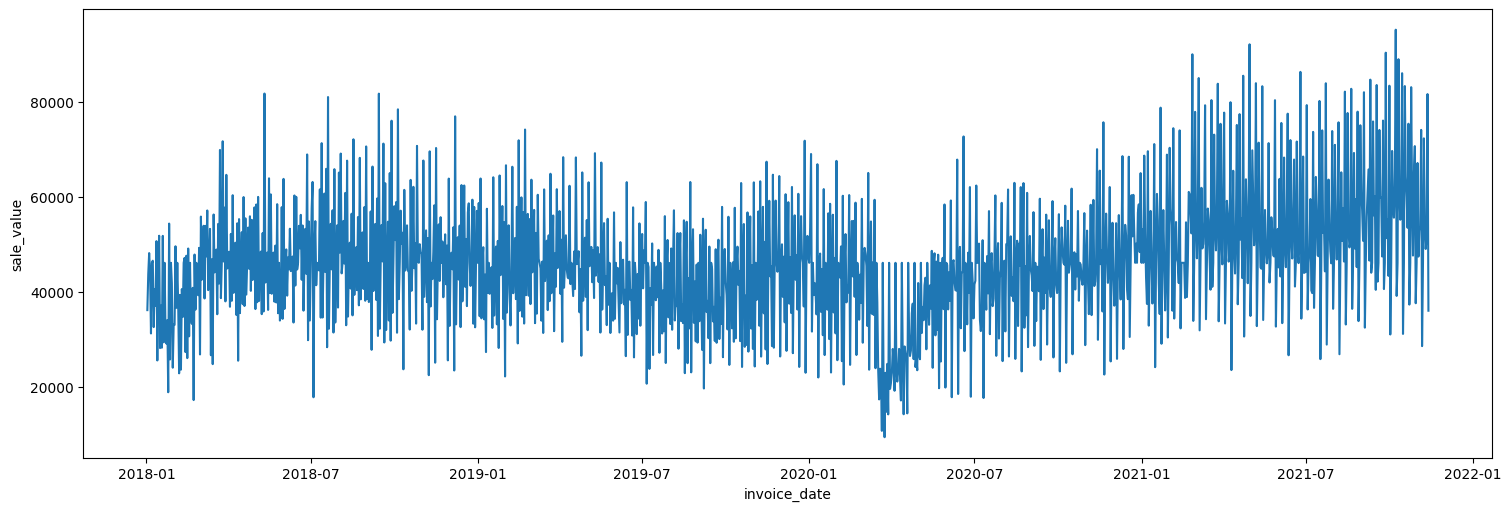

In [41]:
plot_df(daily_sales_mean)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25467.916, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24607.013, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24296.096, Time=4.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25465.918, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23954.302, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23914.628, Time=1.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24236.303, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23915.162, Time=1.67 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23926.061, Time=2.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23955.664, Time=2.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24086.975, Time=1.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24029.385, Time=6.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=23912.703, Time=1.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23951.941, Time=0.69 sec
 ARIMA(2,1,0)(0,0,0

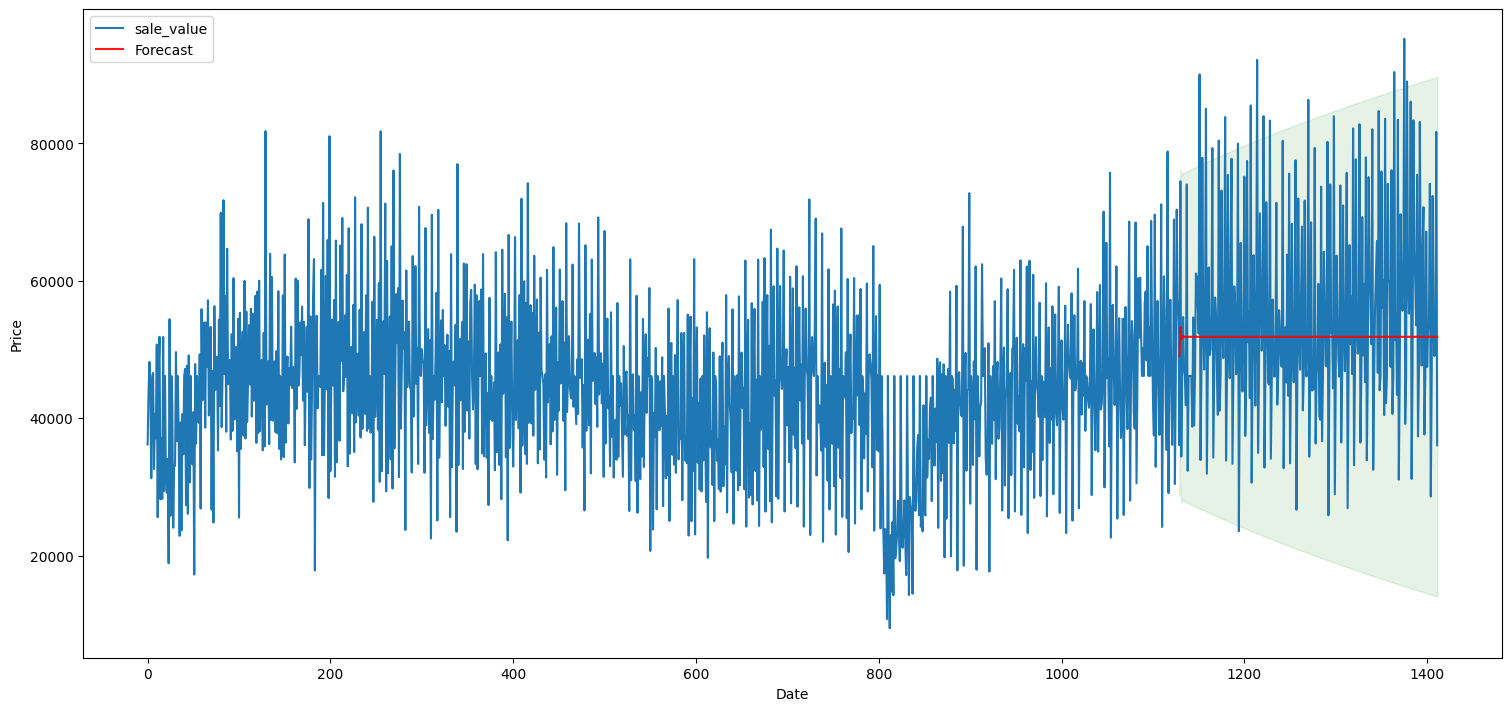

In [42]:
train_arima_model(daily_sales_mean, train_size=0.8)

### Daily Sales Zero

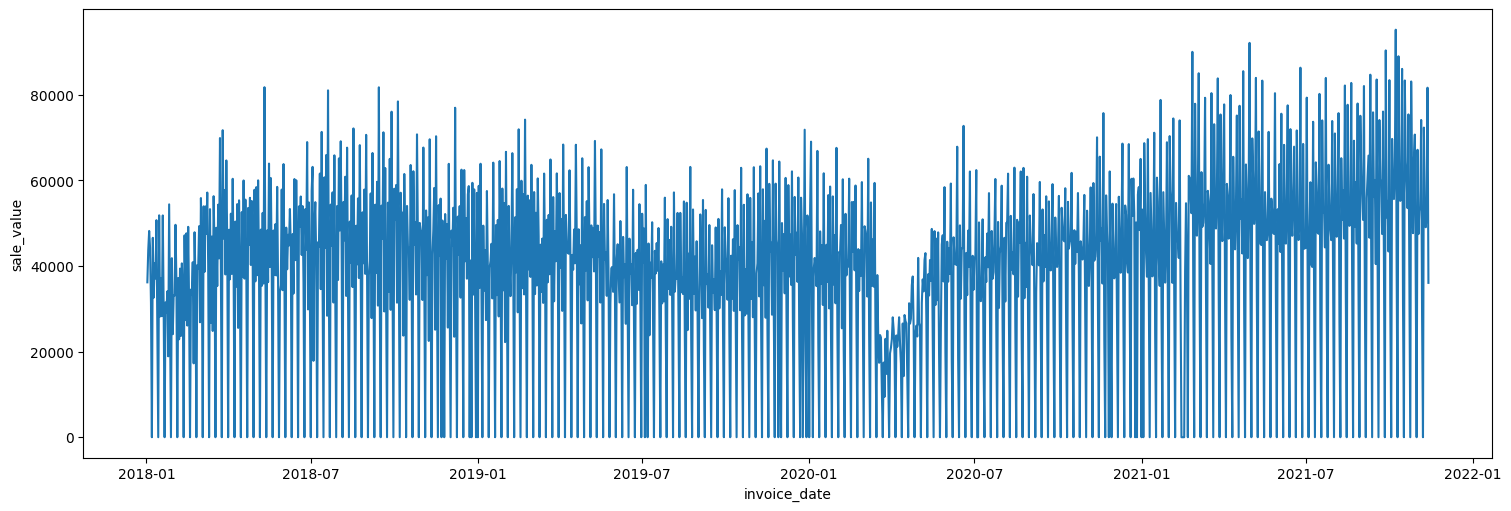

In [43]:
plot_df(daily_sales_zero)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26445.923, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26143.950, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25506.301, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26443.923, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25509.551, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=25408.733, Time=1.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25466.665, Time=1.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=25646.671, Time=1.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25477.363, Time=1.68 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=25465.156, Time=1.56 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 8.971 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


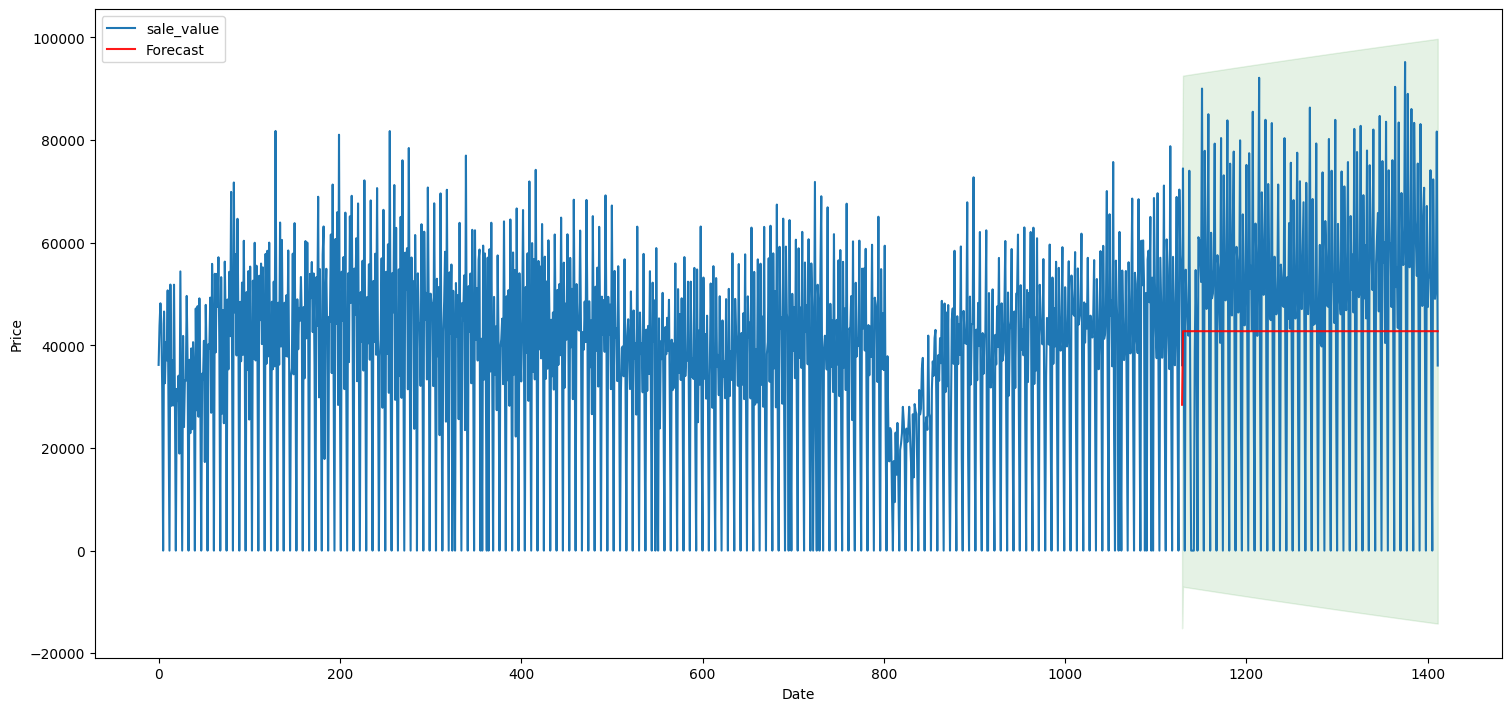

In [44]:
train_arima_model(daily_sales_zero, train_size=0.8)

### Daily Sales interpolate

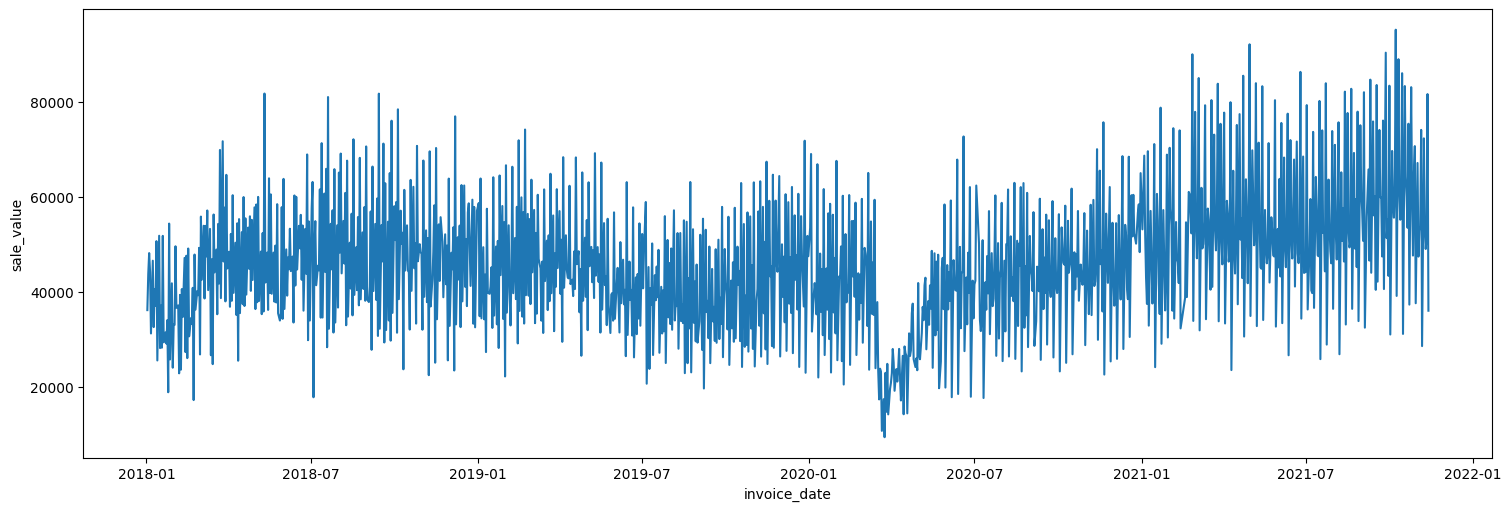

In [45]:
plot_df(daily_sales_interpolate)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25393.120, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24656.715, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24304.456, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25391.121, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24086.515, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24068.264, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24345.896, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24070.157, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24090.377, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24087.663, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24206.200, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24202.735, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=24066.342, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24084.362, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0

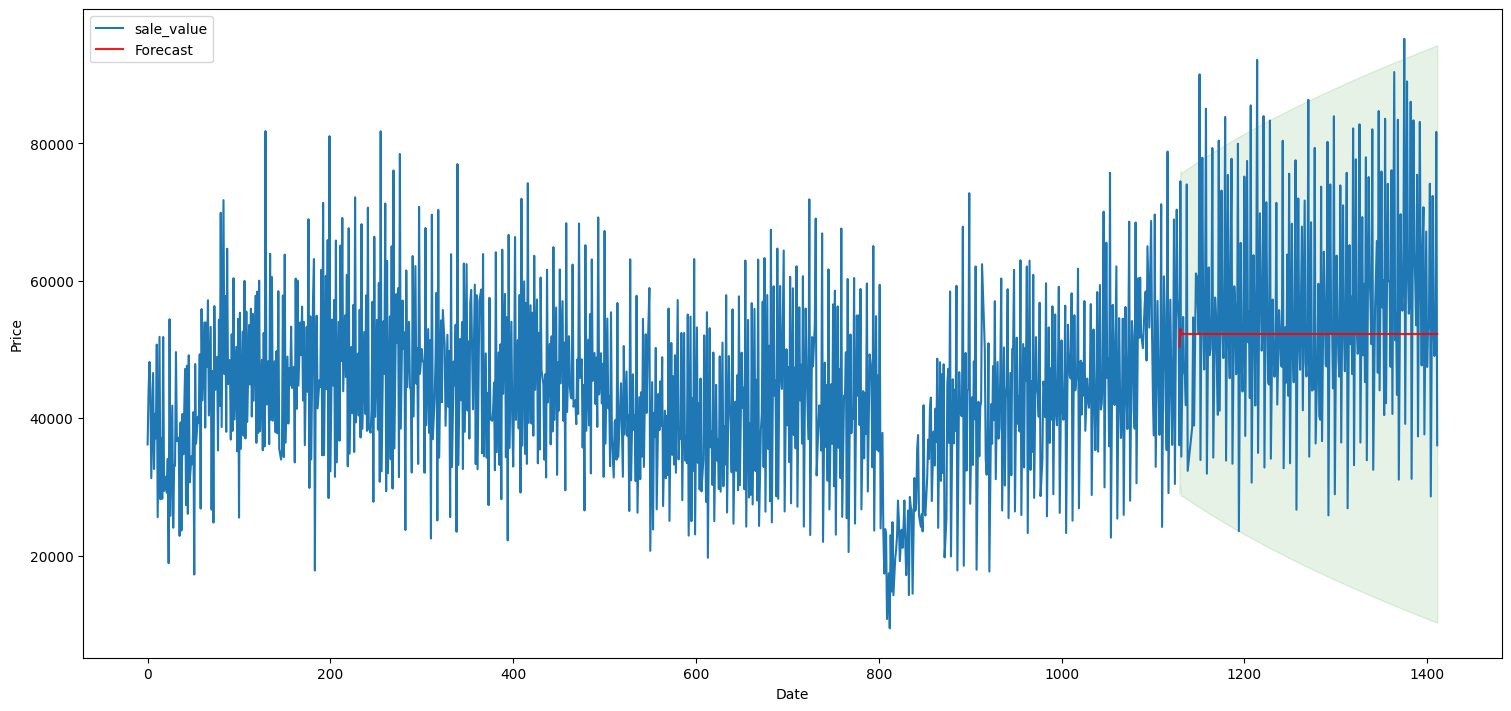

In [46]:
train_arima_model(daily_sales_interpolate, train_size=0.8)

### Weekly Average Mean

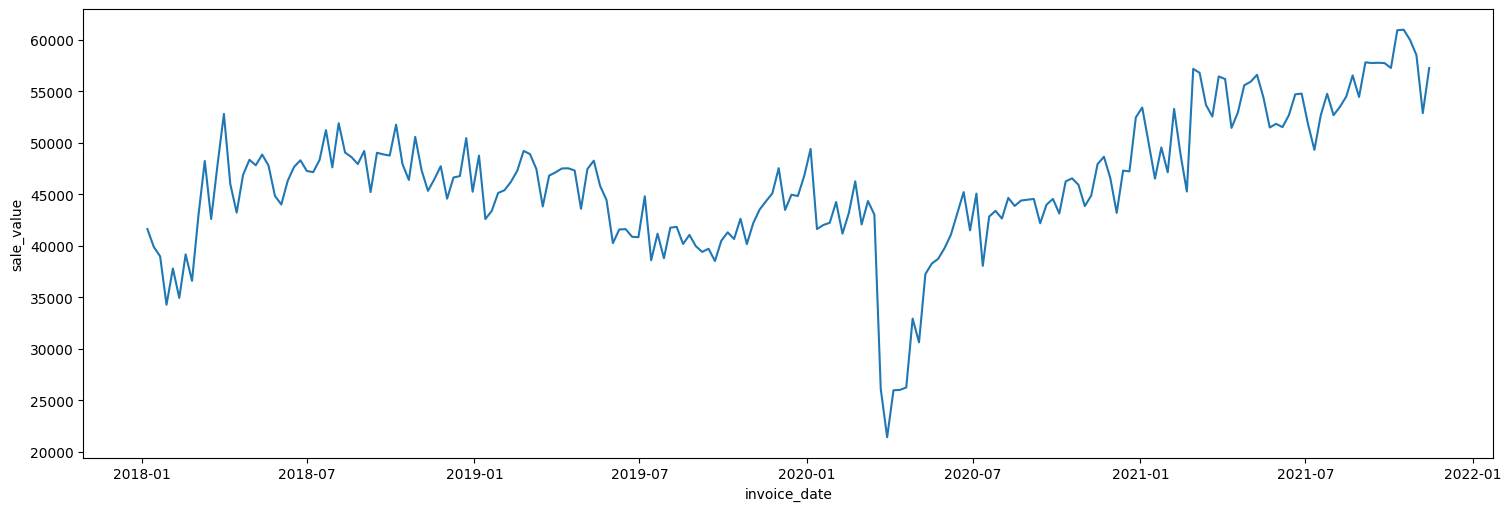

In [47]:
plot_df(weekly_averages_mean)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3213.703, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3040.777, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3122.373, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3903.684, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3038.139, Time=0.56 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3039.656, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3039.978, Time=0.53 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3038.362, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3041.587, Time=1.51 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 3.893 seconds


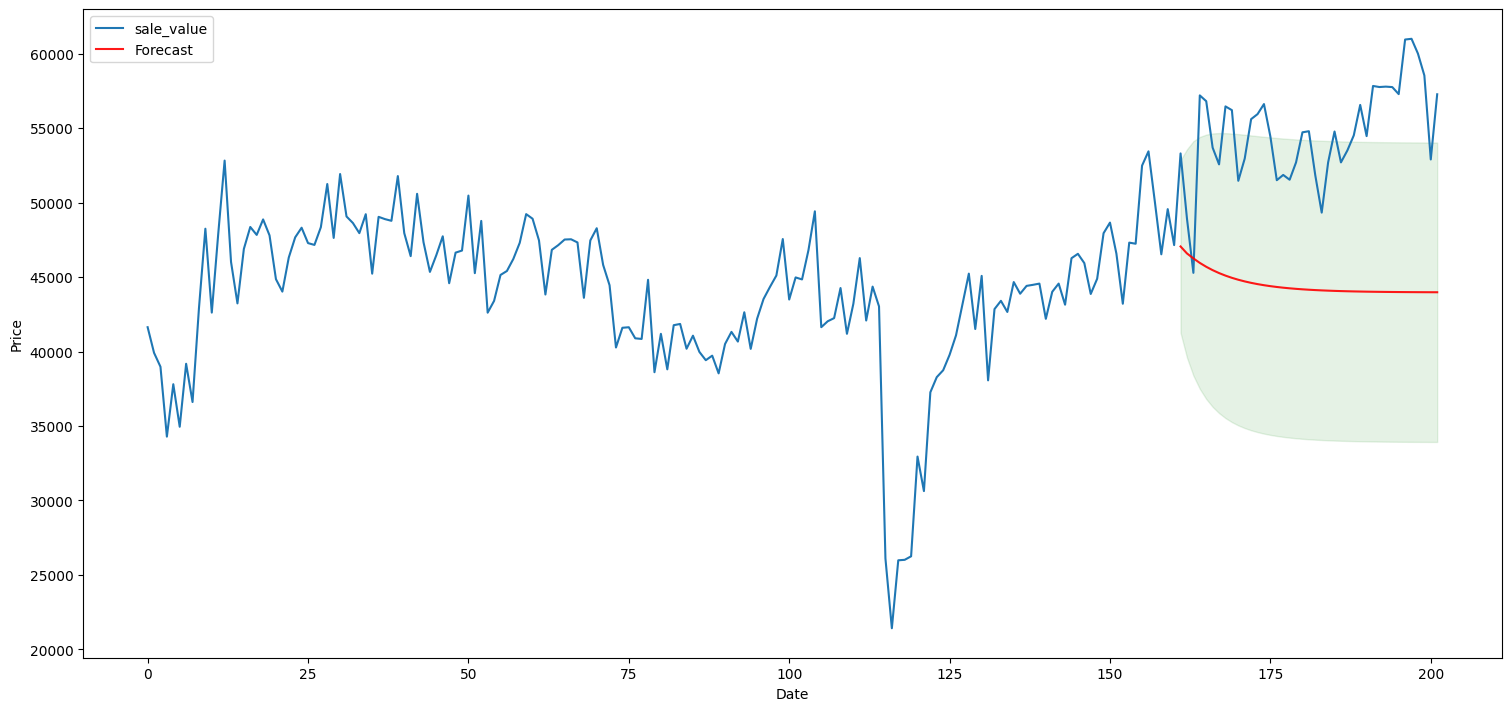

In [48]:
train_arima_model(weekly_averages_mean, train_size=0.8)

### Weekly Average Zero

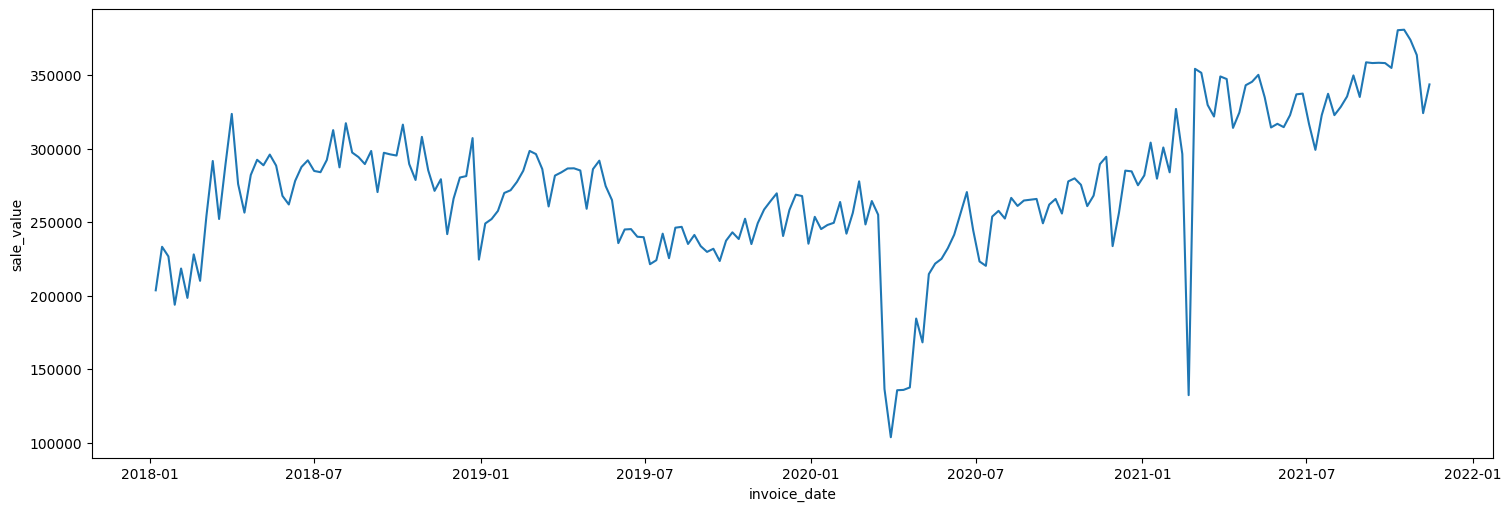

In [49]:
plot_df(weekly_averages_zero)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3659.721, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3660.055, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3659.466, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3657.806, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3659.010, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.218 seconds


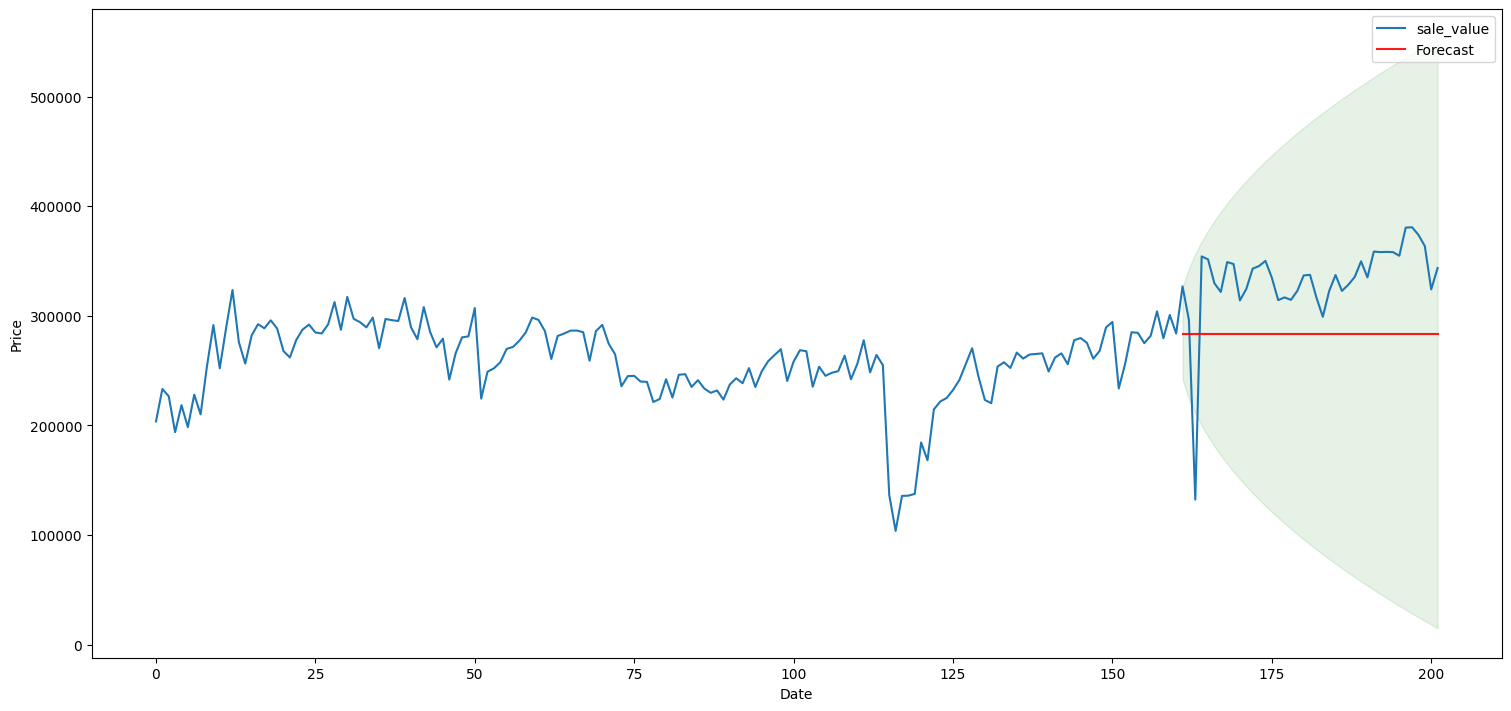

In [50]:
train_arima_model(weekly_averages_zero, train_size=0.8)

### Weekly Average interpolate

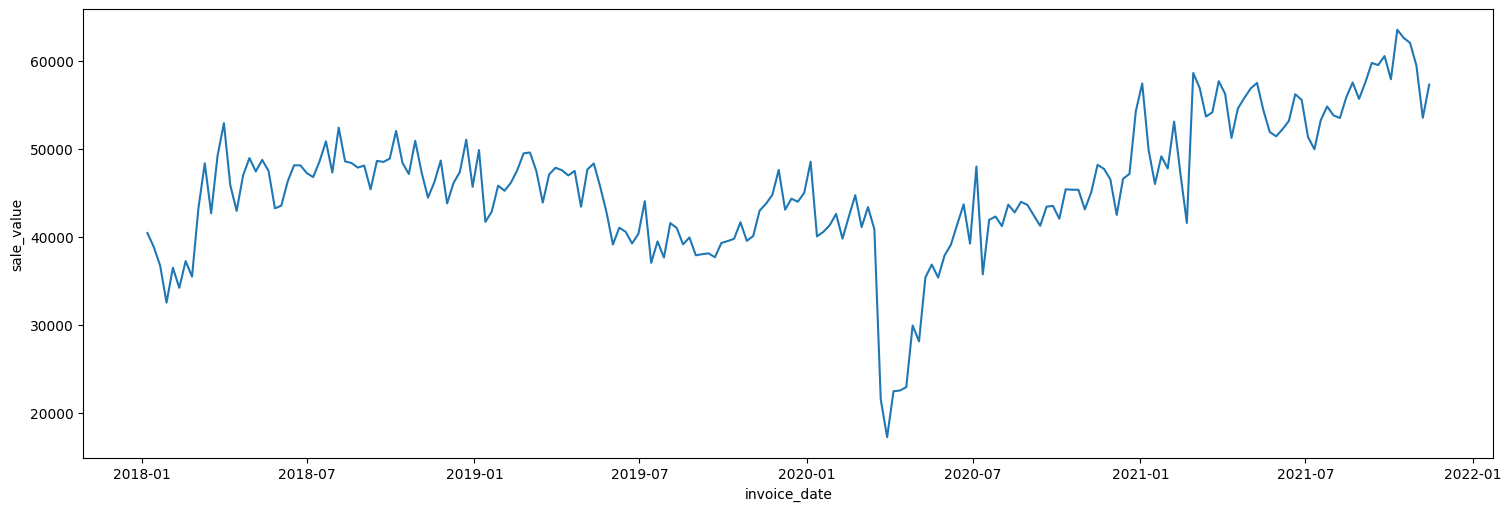

In [51]:
plot_df(weekly_averages_interpolate)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3080.940, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3076.458, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3074.938, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3078.969, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3074.990, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3074.927, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3076.776, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3077.142, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3073.191, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3073.074, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3073.070, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3074.555, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3075.039, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

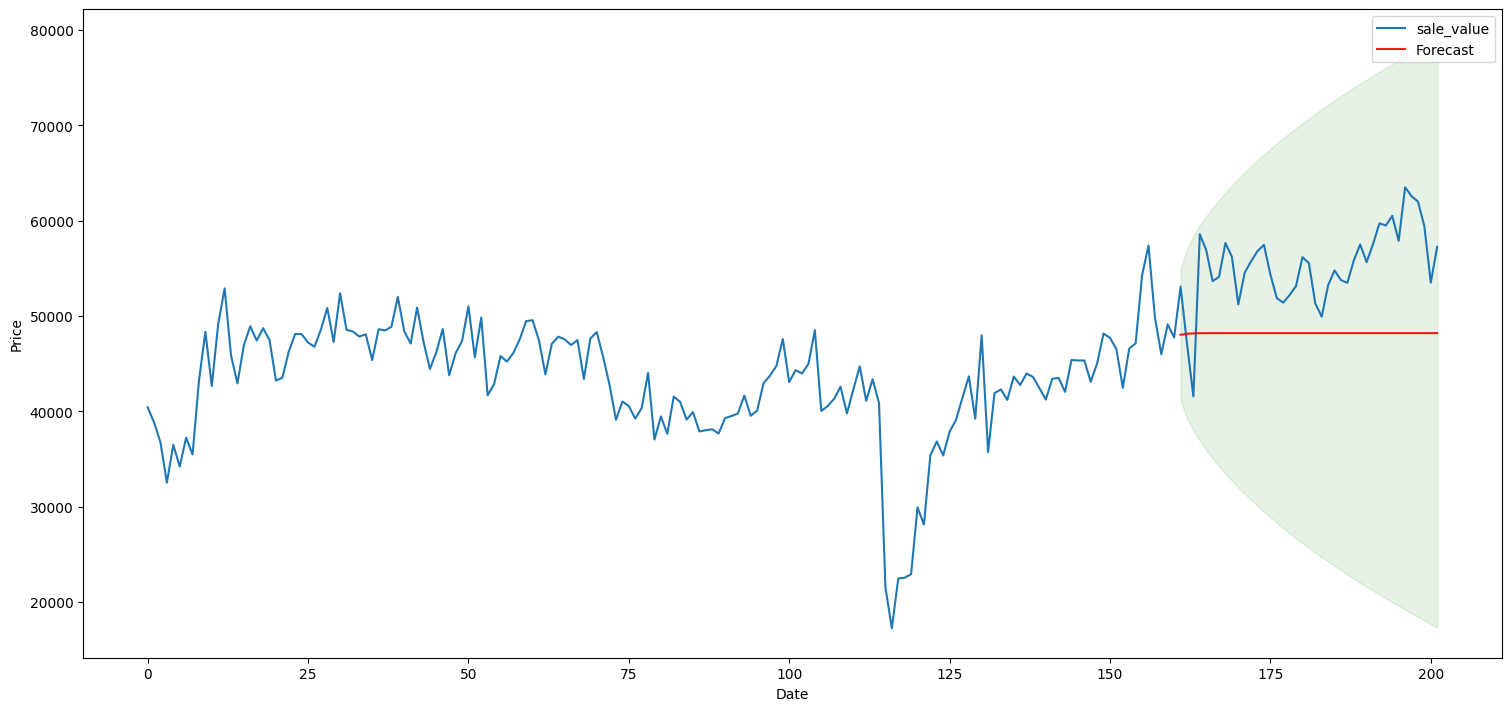

In [52]:
train_arima_model(weekly_averages_interpolate, train_size=0.8)